# Предсказание стоимости жилья
## Постановка задачи и описание исходных данных

### Постановка задачи
Задача - обучить модель линейной регрессии на данных датасета о жилье в Калифорнии в 1990 году и предсказать медианную стоимость дома в жилом массиве. 

Качество полученной модели нужно оценить с помощью метрик `RMSE`, `MAE` и `R2`.

### Описание датасета

Исходный датасет содержит 20_640 строк. В колонках датасета содержатся следующие данные:

* `longitude` — широта;
* `latitude` — долгота;
* `housing_median_age` — медианный возраст жителей жилого массива;
* `total_rooms` — общее количество комнат в домах жилого массива;
* `total_bedrooms` — общее количество спален в домах жилого массива;
* `population` — количество человек, которые проживают в жилом массиве;
* `households` — количество домовладений в жилом массиве;
* `median_income` — медианный доход жителей жилого массива;
* `median_house_value` — медианная стоимость дома в жилом массиве;
* `ocean_proximity` — близость к океану.

На основе данных нужно предсказать медианную стоимость дома в жилом массиве — `median_house_value`. 

## Подготовка данных
### Импорт библиотек
Импортируем необходимые библиотеки и модули. Инициализируем локальную сессию Spark.


In [55]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

from pyspark.ml.regression import LinearRegression

from pyspark.ml.evaluation import RegressionEvaluator

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator
        
RANDOM_SEED = 6666

spark = SparkSession.builder \
                    .master("local") \
                    .appName("EDA California Housing") \
                    .getOrCreate()

### Импорт данных
Импортируем датасет для дальнейшей работы. Предварительно ознакомимся с данными. Значения во всех колонках, кроме `ocean_proximity`, количественные. В `ocean_proximity` - категориальные. Тип численных данных `double`.

In [56]:
df_housing = spark.read.load('/datasets/housing.csv', format="csv", sep=",", inferSchema=True, header="true")
df_housing.printSchema()
df_housing.show(10)

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR B

## Предобработка данных
### Конвертация типов данных
Тип `DoubleType` для количественных колонок датасета кажется избыточным, заменим его на `FloatType`.

In [57]:
string_columns = ['ocean_proximity']
selected_columns = [column for column in df_housing.columns if column not in string_columns]

for column in selected_columns:
    df_housing = df_housing.withColumn(column, F.col(column).cast(FloatType()))
    
df_housing.printSchema()

root
 |-- longitude: float (nullable = true)
 |-- latitude: float (nullable = true)
 |-- housing_median_age: float (nullable = true)
 |-- total_rooms: float (nullable = true)
 |-- total_bedrooms: float (nullable = true)
 |-- population: float (nullable = true)
 |-- households: float (nullable = true)
 |-- median_income: float (nullable = true)
 |-- median_house_value: float (nullable = true)
 |-- ocean_proximity: string (nullable = true)



### Обработка пропусков
Проанализируем наличие пропусков и избавимся от них. Пропуски есть в колонке `total_bedrooms`, они составляют около 1% датасета. Удалим строки с пропусками.

In [58]:
columns = df_housing.columns

for column in columns:
    print('spark', column, df_housing.filter(F.col(column).isNull()).count()) # doesn't work correctly
    print('pandas', column, df_housing.toPandas()[column].isna().sum())
    

spark longitude 0
pandas longitude 0
spark latitude 0
pandas latitude 0
spark housing_median_age 0
pandas housing_median_age 0
spark total_rooms 0
pandas total_rooms 0
spark total_bedrooms 207
pandas total_bedrooms 207
spark population 0
pandas population 0
spark households 0
pandas households 0
spark median_income 0
pandas median_income 0
spark median_house_value 0
pandas median_house_value 0
spark ocean_proximity 0
pandas ocean_proximity 0


In [59]:
df_housing = df_housing.na.drop(how='any')

for column in columns:
    # print('spark', column, df_housing.filter(F.col(column).isin([None, np.nan])).count()) # doesn't work correctly
    print('pandas', column, df_housing.toPandas()[column].isna().sum())

pandas longitude 0
pandas latitude 0
pandas housing_median_age 0
pandas total_rooms 0
pandas total_bedrooms 0
pandas population 0
pandas households 0
pandas median_income 0
pandas median_house_value 0
pandas ocean_proximity 0


### Проверка на дубликаты
Строк-полных дубликатов в данных нет.

In [60]:
print(df_housing.count())
print(df_housing.dropDuplicates().count())

20433


20433


### Проверка выбросов

В таблице есть подозрительные данные, например, домовладения со средним возрастом жильцов от двух лет и ниже, слишком малым количеством домовладений или с количеством комнат меньшим, чем количество домовладений. Оставим их в датасете.



In [61]:
df_housing.toPandas().describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570694,35.633221,28.633093,2636.504395,537.870544,1424.947021,499.433472,3.871162,206864.406250
std,2.003578,2.136348,12.591805,2185.269531,421.385071,1133.208496,382.299225,1.899291,115435.671875
min,-124.349998,32.540001,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800003,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119500.000000
50%,-118.489998,34.259998,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000
75%,-118.010002,37.720001,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264700.000000
max,-114.309998,41.950001,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


In [62]:
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20433,20433,20433,20433,20433,20433,20433,20433,20433,20433
1,mean,-119.57068857990079,35.63322125826324,28.633093525179856,2636.5042333480155,537.8705525375618,1424.9469485635982,499.43346547251997,3.8711616013541663,206864.41315519012,None
2,stddev,2.003577909697097,2.136347649575151,12.591805202182835,2185.269566977601,421.38507007403115,1133.2084897449597,382.2992258828481,1.899291249637732,115435.66709858322,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [63]:
df_housing.summary().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20433,20433,20433,20433,20433,20433,20433,20433,20433,20433
1,mean,-119.57068857990079,35.63322125826324,28.633093525179856,2636.5042333480155,537.8705525375618,1424.9469485635982,499.43346547251997,3.8711616013541663,206864.41315519012,None
2,stddev,2.003577909697097,2.136347649575151,12.591805202182835,2185.269566977601,421.38507007403115,1133.2084897449597,382.2992258828481,1.899291249637732,115435.66709858322,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,25%,-121.8,33.93,18.0,1450.0,296.0,787.0,280.0,2.5637,119500.0,None
5,50%,-118.5,34.26,29.0,2126.0,435.0,1166.0,409.0,3.5363,179700.0,None
6,75%,-118.01,37.72,37.0,3142.0,647.0,1722.0,604.0,4.7437,264700.0,None
7,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [64]:
df_housing.summary().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20433,20433,20433,20433,20433,20433,20433,20433,20433,20433
1,mean,-119.57068857990079,35.63322125826324,28.633093525179856,2636.5042333480155,537.8705525375618,1424.9469485635982,499.43346547251997,3.8711616013541663,206864.41315519012,None
2,stddev,2.003577909697097,2.136347649575151,12.591805202182835,2185.269566977601,421.38507007403115,1133.2084897449597,382.2992258828481,1.899291249637732,115435.66709858322,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,25%,-121.8,33.93,18.0,1450.0,296.0,787.0,280.0,2.5637,119500.0,None
5,50%,-118.5,34.26,29.0,2126.0,435.0,1166.0,409.0,3.5363,179700.0,None
6,75%,-118.01,37.72,37.0,3142.0,647.0,1722.0,604.0,4.7437,264700.0,None
7,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


In [11]:
print('Средний возраст <= 2:', 
      df_housing.filter(F.col('housing_median_age') <= 2).count(), 
      'строки')
print('Количество домовладений <= 5:', 
      df_housing.filter(F.col('households') <= 5).count(), 
      'строки')
print('Количество домовладений больше, чем всего комнат:', 
      df_housing.filter(F.col('households') > F.col('total_rooms')).count(), 
      'строки')

Средний возраст <= 2: 62 строки
Количество домовладений <= 5: 19 строки
Количество домовладений больше, чем всего комнат: 2 строки


## Подготовка датасета для обучения модели
### Выделение численных и текстовых колонок
Подготовим датасет для обучения моделей регрессии. Для этого выделим численные и текстовые колонки.

In [12]:
target = 'median_house_value'
categorical_columns = ['ocean_proximity']
numerical_columns = [el[0] for el in df_housing.dtypes 
                    if el[0] != target and (el[1] == 'int' or el[1] == 'double' or el[1] == 'float')]

In [13]:
df_housing.dtypes

[('longitude', 'float'),
 ('latitude', 'float'),
 ('housing_median_age', 'float'),
 ('total_rooms', 'float'),
 ('total_bedrooms', 'float'),
 ('population', 'float'),
 ('households', 'float'),
 ('median_income', 'float'),
 ('median_house_value', 'float'),
 ('ocean_proximity', 'string')]

### Исследование взаимозависимости переменных
Для упрощения задачи предварительно исследуем связь целевого признака с прочими. Единственный признак, с которым есть сильная корреляция, - `median_income`, то есть медианный доход жителей жилого массива (коэффициент корреляции 0.688).

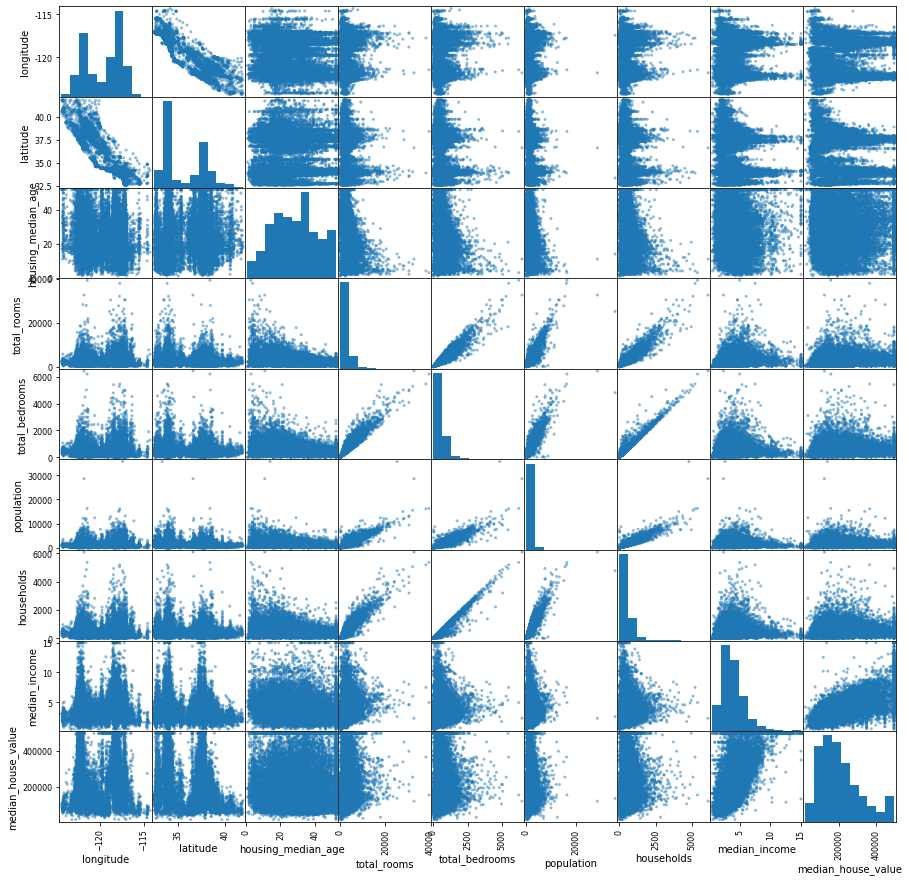

In [14]:
axs = pd.plotting.scatter_matrix(df_housing.toPandas(), figsize=(15, 15))

In [15]:
for column in numerical_columns:
    correlation_k = df_housing.stat.corr(target, column)
    print('Correlation of median_house_value with ', column, ' = ', correlation_k)


Correlation of median_house_value with  longitude  =  -0.04539823246310375
Correlation of median_house_value with  latitude  =  -0.14463820549503434
Correlation of median_house_value with  housing_median_age  =  0.1064320468761554
Correlation of median_house_value with  total_rooms  =  0.13329413480832372
Correlation of median_house_value with  total_bedrooms  =  0.0496861802473462
Correlation of median_house_value with  population  =  -0.02529973228744219
Correlation of median_house_value with  households  =  0.0648935494881425
Correlation of median_house_value with  median_income  =  0.6883554748351046


### Кодирование строковых данных методом OneHotEncoding
Кодируем строковые данные методом OneHotEncoding.

In [16]:
indexer = StringIndexer(inputCols=categorical_columns, 
                        outputCols=[column + '_idx' for column in categorical_columns]) 
df_housing = indexer.fit(df_housing).transform(df_housing)

In [17]:
encoder = OneHotEncoder(inputCols=[column +'_idx' for column in categorical_columns],
                        outputCols=[column + '_ohe' for column in categorical_columns])
df_housing = encoder.fit(df_housing).transform(df_housing)

print_columns = [column for column in df_housing.columns for i in categorical_columns 
                 if (column.startswith(i))]
df_housing.select(print_columns).show(3) 

+---------------+-------------------+-------------------+
|ocean_proximity|ocean_proximity_idx|ocean_proximity_ohe|
+---------------+-------------------+-------------------+
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
|       NEAR BAY|                3.0|      (4,[3],[1.0])|
+---------------+-------------------+-------------------+
only showing top 3 rows



In [18]:
categorical_assembler = VectorAssembler(inputCols=[column + '_ohe' for column in categorical_columns],
                                        outputCol='categorical_features')
df_housing = categorical_assembler.transform(df_housing)

In [19]:
df_housing.select('ocean_proximity_ohe', 'categorical_features').show(5)

+-------------------+--------------------+
|ocean_proximity_ohe|categorical_features|
+-------------------+--------------------+
|      (4,[3],[1.0])|       (4,[3],[1.0])|
|      (4,[3],[1.0])|       (4,[3],[1.0])|
|      (4,[3],[1.0])|       (4,[3],[1.0])|
|      (4,[3],[1.0])|       (4,[3],[1.0])|
|      (4,[3],[1.0])|       (4,[3],[1.0])|
+-------------------+--------------------+
only showing top 5 rows



In [20]:
df_housing.dtypes

[('longitude', 'float'),
 ('latitude', 'float'),
 ('housing_median_age', 'float'),
 ('total_rooms', 'float'),
 ('total_bedrooms', 'float'),
 ('population', 'float'),
 ('households', 'float'),
 ('median_income', 'float'),
 ('median_house_value', 'float'),
 ('ocean_proximity', 'string'),
 ('ocean_proximity_idx', 'double'),
 ('ocean_proximity_ohe', 'vector'),
 ('categorical_features', 'vector')]

### Скалирование числовых значений
Скалируем числовые значения, чтобы избежать неверной интерпретации данных из-за различной размерности.

In [21]:
numerical_assembler = VectorAssembler(inputCols=numerical_columns,
                                      outputCol='numerical_features')
df_housing = numerical_assembler.transform(df_housing) 

standard_scaler = StandardScaler(inputCol='numerical_features',
                                outputCol='numerical_features_scaled')
df_housing = standard_scaler.fit(df_housing).transform(df_housing) 

In [22]:
df_housing.select('numerical_features', 'numerical_features_scaled').show(10)

+--------------------+-------------------------+
|  numerical_features|numerical_features_scaled|
+--------------------+-------------------------+
|[-122.23000335693...|     [-61.005864940591...|
|[-122.22000122070...|     [-61.000872803184...|
|[-122.23999786376...|     [-61.010853270113...|
|[-122.25,37.84999...|     [-61.015845407519...|
|[-122.25,37.84999...|     [-61.015845407519...|
|[-122.25,37.84999...|     [-61.015845407519...|
|[-122.25,37.84000...|     [-61.015845407519...|
|[-122.25,37.84000...|     [-61.015845407519...|
|[-122.26000213623...|     [-61.020837544926...|
|[-122.25,37.84000...|     [-61.015845407519...|
+--------------------+-------------------------+
only showing top 10 rows



### Сбор финального датасета для обучения модели

Составим финальный датасет для обучения моделей. Для обучения только на числовых данных будем использовать колонку `numerical_features_scaled`, для обучения на всех данных - колонку `all_features`. 

Разделим датасет на тренировочную и тестовую выборки.

In [23]:
all_features = ['categorical_features','numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=all_features, 
                                  outputCol='all_features') 
df_housing = final_assembler.transform(df_housing)

# df_housing.select(all_features).show(3) 

In [24]:
df_housing.dtypes


[('longitude', 'float'),
 ('latitude', 'float'),
 ('housing_median_age', 'float'),
 ('total_rooms', 'float'),
 ('total_bedrooms', 'float'),
 ('population', 'float'),
 ('households', 'float'),
 ('median_income', 'float'),
 ('median_house_value', 'float'),
 ('ocean_proximity', 'string'),
 ('ocean_proximity_idx', 'double'),
 ('ocean_proximity_ohe', 'vector'),
 ('categorical_features', 'vector'),
 ('numerical_features', 'vector'),
 ('numerical_features_scaled', 'vector'),
 ('all_features', 'vector')]

### Добавление в финальный датасет векторов без колонок со слабой корреляцией
Поскольку данные в датасете показывают слабую корреляцию с целевым признаком, возможно, что удаление колонок с наиболее слабой корреляцией улучшит качество предсказаний модели. Соберем вектор `selected_all_features` для обучения модели на части числовых данных, где корреляция сильней.

In [25]:
selected_columns = ['housing_median_age', 'total_rooms', 'households', 'median_income']

In [26]:
for column in numerical_columns:
    correlation_k = df_housing.stat.corr(target, column)
    print('Correlation of median_house_value with ', column, ' = ', correlation_k)


Correlation of median_house_value with  longitude  =  -0.04539823246310375
Correlation of median_house_value with  latitude  =  -0.14463820549503434
Correlation of median_house_value with  housing_median_age  =  0.1064320468761554
Correlation of median_house_value with  total_rooms  =  0.13329413480832372
Correlation of median_house_value with  total_bedrooms  =  0.0496861802473462
Correlation of median_house_value with  population  =  -0.02529973228744219
Correlation of median_house_value with  households  =  0.0648935494881425
Correlation of median_house_value with  median_income  =  0.6883554748351046


In [27]:
# скалируем и переведем в вектор числовые колонки
selected_numerical_assembler = VectorAssembler(inputCols=selected_columns,
                                      outputCol='selected_numerical_features')
df_housing = selected_numerical_assembler.transform(df_housing) 

standard_scaler = StandardScaler(inputCol='selected_numerical_features',
                                outputCol='selected_numerical_features_scaled')
df_housing = standard_scaler.fit(df_housing).transform(df_housing) 

In [28]:
# сбор векторов финального датасета без колонок со слабой корреляцией
selected_all_features = ['categorical_features','selected_numerical_features_scaled']

final_assembler = VectorAssembler(inputCols=selected_all_features, 
                                  outputCol='selected_all_features') 
df_housing = final_assembler.transform(df_housing)
# df_housing.dtypes

In [29]:
df_housing.dtypes

[('longitude', 'float'),
 ('latitude', 'float'),
 ('housing_median_age', 'float'),
 ('total_rooms', 'float'),
 ('total_bedrooms', 'float'),
 ('population', 'float'),
 ('households', 'float'),
 ('median_income', 'float'),
 ('median_house_value', 'float'),
 ('ocean_proximity', 'string'),
 ('ocean_proximity_idx', 'double'),
 ('ocean_proximity_ohe', 'vector'),
 ('categorical_features', 'vector'),
 ('numerical_features', 'vector'),
 ('numerical_features_scaled', 'vector'),
 ('all_features', 'vector'),
 ('selected_numerical_features', 'vector'),
 ('selected_numerical_features_scaled', 'vector'),
 ('selected_all_features', 'vector')]

### Выделение тренировочной и тестовой выборки
В финальном датасете выделим обучающую и тестовую выборки.

In [30]:
train_data, test_data = df_housing.randomSplit([.8,.2], seed=RANDOM_SEED)
print(train_data.count(), test_data.count()) 

16349 4084


## Обучение моделей

### Обучение модели на всех имеющихся данных
Инициализируем экземпляр модели линейной регрессии `model_1` и обучим ее на всех данных датасета.

In [31]:
lr = LinearRegression(featuresCol='all_features', labelCol=target, 
                      maxIter=10, regParam=0.3, elasticNetParam=0.8,
                     fitIntercept=True)

model_1 = lr.fit(train_data) 

22/06/29 07:24:54 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/06/29 07:24:54 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


In [32]:
predictions_all_features = model_1.transform(test_data)

predicted_labes = predictions_all_features.select(target, "prediction")
predicted_labes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|183539.39912189392|
|           79000.0|199978.62287173804|
|           73200.0|159346.86543371493|
|           70000.0|168534.26101401832|
|           86400.0| 202308.6889109487|
|          128900.0| 224220.3550711329|
|           70500.0| 183779.1415390732|
|           62500.0|  186997.686544106|
|           75500.0|179614.20867955207|
|           85600.0|206993.49445549666|
|           81800.0| 254463.1310496732|
|           75500.0|157974.94684800121|
|          100600.0| 210130.7538590614|
|          104200.0|220644.24178113264|
|           67500.0|168284.33755128633|
|          128100.0| 235844.3153592794|
|          100500.0|182571.58931722387|
|           92800.0| 230026.1550387562|
|           92100.0|207547.67142008187|
|           86900.0|172639.00391234027|
+------------------+------------------+
only showing top 20 rows



In [33]:
print("Coefficients: ", model_1.coefficients)
print("Intercept: ", model_1.intercept)

Coefficients:  [18043.07787119695,-43378.546440345024,27573.312377149454,15549.76163589632,-22794.37581656387,-22114.063694030916,14484.37152667657,428.43554904772697,29801.51485655819,-47961.855184966626,24293.684371340463,71735.12708041581]
Intercept:  -973524.7467174394


### Обучение модели только на числовых данных датасета
Инициализируем экземпляр модели линейной регрессии `model_2` и обучим ее только на числовых данных датасета.

In [34]:
lr = LinearRegression(featuresCol='numerical_features_scaled', labelCol=target, 
                      maxIter=10, regParam=0.3, elasticNetParam=0.8)

model_2 = lr.fit(train_data) 

In [35]:
predictions_numerical_features = model_2.transform(test_data)

predicted_labes = predictions_numerical_features.select(target, 'prediction')
predicted_labes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|106945.29039508803|
|           79000.0| 156429.3892121259|
|           73200.0|   81168.271808777|
|           70000.0|116312.34329887526|
|           86400.0|154371.39404601976|
|          128900.0|172279.02161671082|
|           70500.0| 135049.5849310225|
|           62500.0| 136888.6391784083|
|           75500.0|130767.16150518088|
|           85600.0|158132.32706078328|
|           81800.0| 206757.4559937776|
|           75500.0| 99009.82995613199|
|          100600.0| 159910.6938234861|
|          104200.0|169806.37919136323|
|           67500.0|112758.44735954609|
|          128100.0|188346.28158913506|
|          100500.0| 131846.5485126148|
|           92800.0|180469.53616430424|
|           92100.0| 161315.9575831322|
|           86900.0|119386.94880273193|
+------------------+------------------+
only showing top 20 rows



In [36]:
print("Coefficients: ", model_2.coefficients)
print("Intercept: ", model_2.intercept)

Coefficients:  [-73353.56524522425,-78475.5759884211,16370.373886113015,-7699.632256485577,36631.43391627091,-52809.857482883715,34876.016102481095,75500.04219893941]
Intercept:  -3069862.5456700153


### Обучение модели `model_3` на числовых и категориальных данных без учета колонок со слабой корреляцией

In [37]:
lr = LinearRegression(featuresCol='selected_all_features', labelCol=target, 
                      maxIter=10, regParam=0.3, elasticNetParam=0.8)

model_3 = lr.fit(train_data) 

In [38]:
predictions_selected_all_features = model_3.transform(test_data)

predicted_labes = predictions_selected_all_features.select(target, 'prediction')
predicted_labes.show() 

+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|192677.32258925098|
|           79000.0|198743.95857179887|
|           73200.0| 162680.1243742636|
|           70000.0|167390.77199917895|
|           86400.0| 202875.9950233515|
|          128900.0| 228139.8914775511|
|           70500.0| 187260.3454584305|
|           62500.0|  189940.589841106|
|           75500.0| 181297.8994359511|
|           85600.0|209941.08741292715|
|           81800.0|258364.26812673826|
|           75500.0|167299.55954142177|
|          100600.0|217041.59704133405|
|          104200.0|226705.73257978252|
|           67500.0|177306.12222348058|
|          128100.0|239630.45599508166|
|          100500.0| 188946.1783129111|
|           92800.0|231243.64899209136|
|           92100.0| 207823.7840537595|
|           86900.0| 177330.9640376164|
+------------------+------------------+
only showing top 20 rows



In [39]:
print("Coefficients: ", model_3.coefficients)
print("Intercept: ", model_3.intercept)

Coefficients:  [15771.873657074497,-48866.444743754844,35117.504091070594,26812.67802052772,16406.998247109383,-7044.99413225158,16066.494438654341,74454.26051688912]
Intercept:  6045.183124084511


## Анализ результатов
Оценим результаты работы моделей по метрикам качества `RMSE`, `MAE`, `R2`. 

`R2` показывает, какая доля ответов предсказана верно. 

`RMSE` и `MAE` имеет смысл сравнивать с целевой метрикой - `median_house_value`. Обе эти метрики показывают среднее отклонение предсказания от фактического значения целевого признака, `MAE` - среднее абсолютное отклонение,  `RMSE` - среднее квадратичное отклонение.

Лучшие значения по всем метрикам показала `model_1`, обученная на всей выборке, включая все численные и категориальные данные. Метрики этой модели на тренировочной выборке: 

```
RMSE:  69323.03674386359
r2:  0.6379039043421506
MAE:  49953.16799972833
```

На тестовой выборке:
```
RMSE: 68980.75004150809
r2:  0.6481462845279105
MAE:  50251.90046042885
```

Качество предсказаний модели довольно низкое: MAE и RMSE на тренировочной выборке составляют примерно 25 - 35 % от медианного и среднего значений целевого признака. 

Другие две модели показали себя еще хуже. При этом изменение параметров линейной регрессии влияет на точность предсказаний незначительно, так же незначительно ухудшает предсказания исключение из обучающей выборки колонок со слабой корреляцией с целевым признаком. Влияние RANDOM_SEED на результат оказалось значительней, чем изменение параметров регрессии.

In [40]:
train_data.select(target).describe().toPandas()

,summary,median_house_value
0,count,16349
1,mean,206063.4436968622
2,stddev,115207.01928871479
3,min,14999.0
4,max,500001.0


In [41]:
all_metrics = pd.DataFrame(columns=['model', 'R2_train', 'RMSE_train', 'MAE_train', 
                                    'R2_test', 'RMSE_test', 'MAE_test'])
all_metrics

,model,R2_train,RMSE_train,MAE_train,R2_test,RMSE_test,MAE_test


###  Оценка `model_1`, обученной на всех данных

In [42]:
# на тренировочных данных
trainingSummary = model_1.summary
r2_train = trainingSummary.rootMeanSquaredError
rmse_train = trainingSummary.r2
mae_train = trainingSummary.meanAbsoluteError
print("RMSE: ", r2_train)
print("r2: ", rmse_train)
print("MAE: ", mae_train)

RMSE:  69323.03674386359
r2:  0.6379039043421506
MAE:  49953.16799972833


In [43]:
# на тестовых данных
# Create regression evaluator
regressionEvaluator = RegressionEvaluator(predictionCol='prediction', 
                                          labelCol=target, metricName='rmse')
# RMSE
rmse_test = regressionEvaluator.evaluate(predictions_all_features)
print('RMSE:', rmse_test)

# R2
r2_test = regressionEvaluator.setMetricName("r2").evaluate(predictions_all_features)
print('r2: ', r2_test)

# MAE
mae_test = regressionEvaluator.setMetricName("mae").evaluate(predictions_all_features)
print('MAE: ', mae_test)

RMSE: 68980.75004150809
r2:  0.6481462845279105
MAE:  50251.90046042885


In [44]:
all_metrics.loc[0] = ['model_1', r2_train, rmse_train, mae_train, r2_test, rmse_test, mae_test]
all_metrics

,model,R2_train,RMSE_train,MAE_train,R2_test,RMSE_test,MAE_test
0,model_1,69323.036744,0.637904,49953.168,0.648146,68980.750042,50251.90046


### Оценка `model_2`, обученной только на числовых данных

In [45]:
# на тренировочных данных
trainingSummary = model_2.summary
r2_train = trainingSummary.rootMeanSquaredError
rmse_train = trainingSummary.r2
mae_train = trainingSummary.meanAbsoluteError
print("RMSE: ", r2_train)
print("r2: ", rmse_train)
print("MAE: ", mae_train)

RMSE:  70260.19092118232
r2:  0.6280476258554791
MAE:  50998.26754360758


In [46]:
# на тестовых данных
# Create regression evaluator
regressionEvaluator = RegressionEvaluator(predictionCol='prediction', 
                                          labelCol=target, metricName='rmse')
# RMSE
rmse_test = regressionEvaluator.evaluate(predictions_numerical_features)
print('RMSE:', rmse_test)

# R2
r2_test = regressionEvaluator.setMetricName("r2").evaluate(predictions_numerical_features)
print('r2: ', r2_test)

# MAE
mae_test = regressionEvaluator.setMetricName("mae").evaluate(predictions_numerical_features)
print('MAE: ', mae_test)

RMSE: 69467.68530461306
r2:  0.6431612795585917
MAE:  50881.31015351951


In [47]:
all_metrics.loc[1] = ['model_2', r2_train, rmse_train, mae_train, r2_test, rmse_test, mae_test]
all_metrics

,model,R2_train,RMSE_train,MAE_train,R2_test,RMSE_test,MAE_test
0,model_1,69323.036744,0.637904,49953.168000,0.648146,68980.750042,50251.900460
1,model_2,70260.190921,0.628048,50998.267544,0.643161,69467.685305,50881.310154


### Оценка `model_3`, обученной на числовых и категориальных данных без учета колонок со слабой корреляцией

In [48]:
# на тренировочных данных
trainingSummary = model_3.summary
r2_train = trainingSummary.rootMeanSquaredError
rmse_train = trainingSummary.r2
mae_train = trainingSummary.meanAbsoluteError
print("RMSE: ", r2_train)
print("r2: ", rmse_train)
print("MAE: ", mae_train)

RMSE:  72627.4126298682
r2:  0.6025615969503822
MAE:  52926.35148848406


In [49]:
# на тестовых данных
# Create regression evaluator
regressionEvaluator = RegressionEvaluator(predictionCol='prediction', 
                                          labelCol=target, metricName='rmse')
# RMSE
rmse_test = regressionEvaluator.evaluate(predictions_selected_all_features)
print('RMSE:', rmse_test)

# R2
r2_test = regressionEvaluator.setMetricName("r2").evaluate(predictions_selected_all_features)
print('r2: ', r2_test)

# MAE
mae_test = regressionEvaluator.setMetricName("mae").evaluate(predictions_selected_all_features)
print('MAE: ', mae_test)

RMSE: 72654.08731731746
r2:  0.6096749536065509
MAE:  53151.0621465244


In [50]:
all_metrics.loc[2] = ['model_3', r2_train, rmse_train, mae_train, r2_test, rmse_test, mae_test]
all_metrics

,model,R2_train,RMSE_train,MAE_train,R2_test,RMSE_test,MAE_test
0,model_1,69323.036744,0.637904,49953.168000,0.648146,68980.750042,50251.900460
1,model_2,70260.190921,0.628048,50998.267544,0.643161,69467.685305,50881.310154
2,model_3,72627.412630,0.602562,52926.351488,0.609675,72654.087317,53151.062147


## Заключение
### Постановка задачи
### Исходные данные исследования
Исходные данные для исследования представляют собой датасет на 20_640 строк. Данные содержат малое количество пропусков. Строки с пропусками были удалены. Данные не содержат значимое количество выбросов и ошибок. В целом данные пригодны к исследованию.

После предобработки датасет для обучения моделей содержит 20_433 строк без пропусков.

Данные показывают слабую корреляцию целевого признака с прочими признаками, что затрудняет обучение модели.

### Подготовка датасета
Данные были разделены на числовые и категориальные. Категориальные данные были кодированы методом OneHotEncoding и превращены в вектор.

Числовые данные были проскалированы, чтоб избежать неверной интерпретации значимости данных, и также превращены в вектор.

По итогу этих преобразований в датасете получен вектор для обучения модели, содержащий только числовые данные, - `numerical_features_scaled`, и вектор, содержащий все числовые и категориальные данные - `all_features`.

Кроме того, в датасет были добавлены два вектора, исключающие из рассмотрения колонки со слабой корреляцией данных, - `selected_numerical_features_scaled` (без категориальных данных) и `selected_all_features`.

Далее датасет был разделен на обучающую и тестовую выборку, на которых обучались модели.

### Обучение моделей
Было инициализировано и обучено три модели линейной регрессии: 

* `model_1` - на всех данных датасета, числовых и категориальных;
* `model_2` - на всех числовых данных датасета без категориальных;
* `model_3` - на части числовых данных датасета (за исключением колонок со слабой корреляцией с целевым признаком) и всех категориальных данных.

Для обучения `model_3` последовательно тестировались разные комбинации колонок, но все они давали худший результат, чем у других моделей.

Лучший результат показала `model_1`, обученная на всех данных датасета.

В целом модели показали низкую чувствительность к подбору параметров и обучающим данным, существенно выше оказалась чувствительность к RANDOM_SEED. 

Характеристики полученных моделей приведены в таблице:

In [51]:
display(all_metrics)

,model,R2_train,RMSE_train,MAE_train,R2_test,RMSE_test,MAE_test
0,model_1,69323.036744,0.637904,49953.168000,0.648146,68980.750042,50251.900460
1,model_2,70260.190921,0.628048,50998.267544,0.643161,69467.685305,50881.310154
2,model_3,72627.412630,0.602562,52926.351488,0.609675,72654.087317,53151.062147


### Анализ результатов
Лучшие значения по всем метрикам показала `model_1`, обученная на всей выборке, включая численные и категориальные данные. Метрики этой модели на тренировочной выборке: 

```
RMSE:  69323.03674386359
r2:  0.6379039043421506
MAE:  49953.16799972833
```

На тестовой выборке:
```
RMSE: 68980.75004150809
r2:  0.6481462845279105
MAE:  50251.90046042885
```

Качество предсказаний модели довольно низкое: MAE и RMSE на тренировочной выборке составляют примерно 25 - 35 % от медианного и среднего значений целевого признака. 

###  Визуализация предсказания
Визуализируем результат предсказаний лучшей из трех моделей. Как видно из графика, модель иногда предсказывает отрицательную стоимость жилья, что следует устранить.

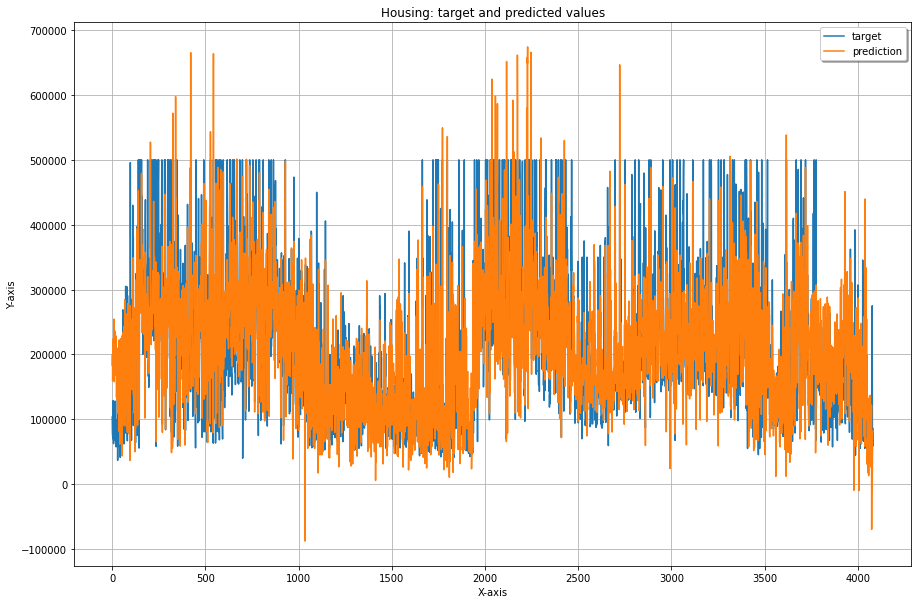

<Figure size 432x288 with 0 Axes>

In [52]:
x_ax = range(0, test_data.count())
predictedLabes = predictions_all_features.select(target, 'prediction')
predictedLabes.columns
y_prediction = predictedLabes.select('prediction').collect()
y_target = predictedLabes.select(target).collect()  

plt.figure(figsize=(15, 10))
plt.plot(x_ax, y_target, label="target")
plt.plot(x_ax, y_prediction, label="prediction")
plt.title("Housing: target and predicted values")
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='best',fancybox=True, shadow=True)
plt.grid(True)
fig = plt.figure()
plt.show()

### Вывод
Лучшей признана модель линейной регрессии `model_1`, обученная на всех численных и категориальных данных датасета. Модель рекомендована к доработке. 

Кроме того, следует обучить на этом датасете другие типы моделей, возможно, они дадут более точный результат предсказаний.

In [53]:
#  закрыть сессию
spark.stop()